# Generative Adversarial Network (GANs)

1. The first tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN).
2. The second tutorial will use a TF-Hub module based on a generative adversarial network (GAN). The module maps from N-dimensional vectors, called latent space, to RGB images. Two examples are provided:
    - Mapping from latent space to images, and
    - Given a target image, using gradient descent to find a latent vector that generates an image similar to the target image.
3. pix2pix: Image-to-image translation with a conditional GAN
4. CycleGAN: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks


- GAN (Generative Adversarial Network):

  - Function: GANs are comprised of two neural networks: a generator and a discriminator. The generator creates synthetic data, while the discriminator learns to distinguish between real and fake data.
  - Objective: The generator aims to produce data that is indistinguishable from real data, while the discriminator aims to improve its ability to differentiate between real and fake data.
  - Applications: GANs are used for generating images, videos, and other types of data, as well as tasks like image-to-image translation and data augmentation.

- Conditional GAN:

  - Function: A conditional GAN (cGAN) extends the GAN framework by introducing conditional information. It conditions both the generator and the discriminator on additional information, such as class labels or specific attributes.
  - Objective: By incorporating conditional information, cGANs allow for more controlled generation, enabling the generation of data based on specified attributes or characteristics.
  - Applications: Conditional GANs are used in tasks where control over generated outputs is crucial, such as image manipulation, image synthesis conditioned on specific attributes, and style transfer.

- CycleGAN:

  - Function: CycleGAN is a type of GAN that focuses on unpaired image-to-image translation without requiring aligned datasets.
  - Objective: It aims to learn mappings between two domains (e.g., horses to zebras) without direct correspondences between individual images in the datasets.
  - Applications: CycleGAN is useful for style transfer, converting images from one domain to another (e.g., changing the style of paintings, converting images between different visual domains).

## What are GANs?
[Generative Adversarial Networks](https://arxiv.org/abs/1406.2661) (GANs) are one of the most interesting ideas in computer science today. Two models are trained simultaneously by an adversarial process. A *generator* ("the artist") learns to create images that look real, while a *discriminator* ("the art critic") learns to tell real images apart from fakes.

![A diagram of a generator and discriminator](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

During training, the *generator* progressively becomes better at creating images that look real, while the *discriminator* becomes better at telling them apart. The process reaches equilibrium when the *discriminator* can no longer distinguish real images from fakes.

![A second diagram of a generator and discriminator](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

This first example demonstrates this process on the MNIST dataset. The following animation shows a series of images produced by the *generator* as it was trained for 50 epochs. The images begin as random noise, and increasingly resemble hand written digits over time.

To learn more about GANs, see MIT's [Intro to Deep Learning](http://introtodeeplearning.com/) course.

### Setup

In [1]:
# To generate GIFs
!pip install imageio

In [2]:
import os
import glob
import time
import imageio
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

/opt/conda/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [3]:
import subprocess
from torchvision import datasets, transforms

dataset_url = "https://github.com/xinhuolin/TEM-ImageNet-v1.3.git"
dataset_dir = "./data/TEM-ImageNet-v1.3"

if not os.path.exists(dataset_dir):
    print("Dataset not found, downloading...")
    subprocess.run(["git", "clone", dataset_url, dataset_dir])
else:
    print("Dataset already exists, skipping download.")

transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

base_dir = "./data/TEM-ImageNet-v1.3/image"
target_subdir = os.path.join(base_dir, "data")
if not os.path.exists(target_subdir):
    os.makedirs(target_subdir)
    print(f"Created directory: {target_subdir}")
else:
    print(f"Directory already exists: {target_subdir}")

for item in os.listdir(base_dir):
    item_path = os.path.join(base_dir, item)
    if os.path.isdir(item_path) and item == "data":
        continue
    if os.path.isfile(item_path):
        shutil.move(item_path, target_subdir)
        print(f"Moved file {item} to {target_subdir}")

dataset = datasets.ImageFolder(root=os.path.join(dataset_dir, 'image'), transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Dataset already exists, skipping download.
Directory already exists: ./data/TEM-ImageNet-v1.3/image/data


In [4]:
BUFFER_SIZE = len(dataset)
BATCH_SIZE = 64

## Create the models

### The Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 14*14*256, bias=False),
            nn.BatchNorm1d(14*14*256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Unflatten(1, (256, 14, 14)),
            
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=1, padding=2, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.ConvTranspose2d(64, 1, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)


Use the (as yet untrained) generator to create an image.

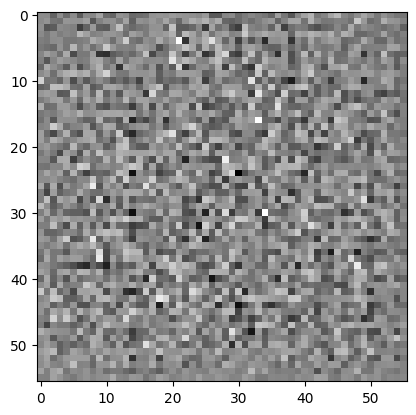

In [6]:
generator = Generator()

noise = torch.from_numpy(np.random.normal(size=(1, 100)).astype(np.float32))
generator.eval()
with torch.no_grad():
    generated_image = generator(noise)

image_to_plot = generated_image[0, 0, :, :].cpu().numpy()

plt.imshow(image_to_plot, cmap='gray')
plt.show()

### The Discriminator

The discriminator is a CNN-based image classifier.

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=2),  # (batch, 64, 14, 14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),  # (batch, 128, 7, 7)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(128*14*14, 1)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [8]:
discriminator = Discriminator()
decision = discriminator(generated_image)
print (decision)

tensor([[0.0330]], grad_fn=<AddmmBackward0>)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

### Generator loss
The goal of the generator is to produce realistic-looking data that can deceive the discriminator. Its loss function encourages the generated samples to resemble real samples. The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

The discriminator and the generator optimizers are different since you will train two networks separately.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

## Define the training loop


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [10]:

def train_step(real_images, noise_dim=100):
    batch_size = real_images.size(0)
    
    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)
    
    gen_optimizer.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device=device)
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images)
    gen_loss = criterion(fake_outputs, real_labels)
    gen_loss.backward()
    gen_optimizer.step()
    
    disc_optimizer.zero_grad()
    real_outputs = discriminator(real_images)
    real_loss = criterion(real_outputs, real_labels)
    fake_outputs = discriminator(fake_images.detach())
    fake_loss = criterion(fake_outputs, fake_labels)
    disc_loss = real_loss + fake_loss
    disc_loss.backward()
    disc_optimizer.step()
    
    return gen_loss.item(), disc_loss.item()


In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

def generate_and_save_images(model, epoch, test_input):
    os.makedirs('./runs', exist_ok=True)
    model.eval()
    with torch.no_grad():
        generated = model(test_input).cpu()
    save_image(generated, f'./runs/image_at_epoch_{epoch:04d}.png', normalize=True)
    model.train()

def train(generator, discriminator, train_loader, epochs, noise_dim=100, save_every=15, checkpoint_dir='./checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    fixed_noise = torch.randn(16, noise_dim, device=device)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        gen_loss_total = 0
        disc_loss_total = 0
        for real_images, _ in train_loader:
            real_images = real_images.to(device)
            gen_loss, disc_loss = train_step(real_images, noise_dim)
            gen_loss_total += gen_loss
            disc_loss_total += disc_loss
        
        avg_gen_loss = gen_loss_total / len(train_loader)
        avg_disc_loss = disc_loss_total / len(train_loader)
        
        generate_and_save_images(generator, epoch, fixed_noise)
        
        if epoch % save_every == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'gen_optimizer_state_dict': gen_optimizer.state_dict(),
                'disc_optimizer_state_dict': disc_optimizer.state_dict(),
            }, os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch}.pth'))
        
        print(f'Epoch [{epoch}/{epochs}]  Gen Loss: {avg_gen_loss:.4f}  Disc Loss: {avg_disc_loss:.4f}  Time: {time.time()-start_time:.2f}s')

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [12]:
train(generator, discriminator, dataloader, epochs=50)

Epoch [1/50]  Gen Loss: 8.0700  Disc Loss: 0.2427  Time: 17.85s
Epoch [2/50]  Gen Loss: 7.3409  Disc Loss: 0.3466  Time: 16.87s
Epoch [3/50]  Gen Loss: 6.2860  Disc Loss: 0.3983  Time: 16.68s
Epoch [4/50]  Gen Loss: 1.4675  Disc Loss: 0.8954  Time: 16.85s
Epoch [5/50]  Gen Loss: 1.5421  Disc Loss: 0.8153  Time: 16.83s
Epoch [6/50]  Gen Loss: 1.7993  Disc Loss: 0.6727  Time: 16.84s
Epoch [7/50]  Gen Loss: 1.7919  Disc Loss: 0.6518  Time: 16.84s
Epoch [8/50]  Gen Loss: 1.6478  Disc Loss: 0.7907  Time: 16.89s
Epoch [9/50]  Gen Loss: 1.8434  Disc Loss: 0.6365  Time: 16.88s
Epoch [10/50]  Gen Loss: 1.7488  Disc Loss: 0.6449  Time: 16.85s
Epoch [11/50]  Gen Loss: 1.7570  Disc Loss: 0.6244  Time: 16.87s
Epoch [12/50]  Gen Loss: 1.6705  Disc Loss: 0.7143  Time: 16.88s
Epoch [13/50]  Gen Loss: 1.4861  Disc Loss: 0.8410  Time: 16.84s
Epoch [14/50]  Gen Loss: 1.3565  Disc Loss: 0.9253  Time: 16.84s
Epoch [15/50]  Gen Loss: 1.2489  Disc Loss: 0.9522  Time: 17.07s
Epoch [16/50]  Gen Loss: 1.3747  D

## Create a GIF


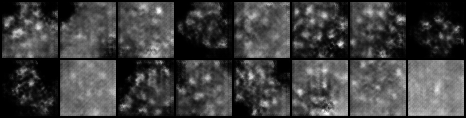

In [13]:
from PIL import Image

# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('runs/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(50)

Use `imageio` to create an animated gif using the images saved during training.

In [14]:
anim_file = 'runs/dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('runs/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

/tmp/ipykernel_22546/2350883945.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_22546/2350883945.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


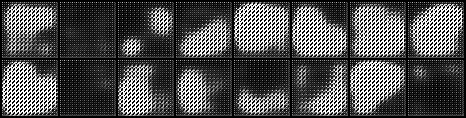

In [15]:
from IPython.display import Image, display

display(Image(filename=anim_file))

# pix2pix: Image-to-image translation with a conditional GAN

This tutorial demonstrates how to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In this example, your network will generate images of building facades using the [CMP Facade Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) provided by the [Center for Machine Perception](http://cmp.felk.cvut.cz/) at the [Czech Technical University in Prague](https://www.cvut.cz/). To keep it short, you will use a [preprocessed copy]((https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/)) of this dataset created by the pix2pix authors.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.

In [16]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import os
import pathlib
import time
import datetime

from PIL import Image
from matplotlib import pyplot as plt
from IPython import display

## Load the dataset

(256, 256)
torch.Size([1, 256, 256])


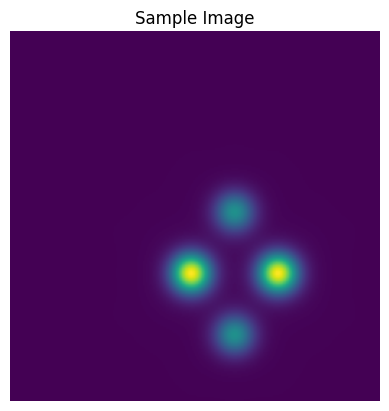

In [17]:
# Each original image is of size `256 x 512` containing two `256 x 256` images:

from PIL import Image

# Read a sample image
sample_image_path = './data/TEM-ImageNet-v1.3/noNoise/00001.png'
sample_image = Image.open(sample_image_path)
print(sample_image.size)  # (width, height)

# Convert to tensor for consistency (optional)
transform = transforms.ToTensor()
sample_image_tensor = transform(sample_image)
print(sample_image_tensor.shape)  # (C, H, W)

plt.figure()
plt.imshow(sample_image)
plt.axis('off')
plt.title('Sample Image')
plt.show()


(256, 256)
torch.Size([1, 256, 256])


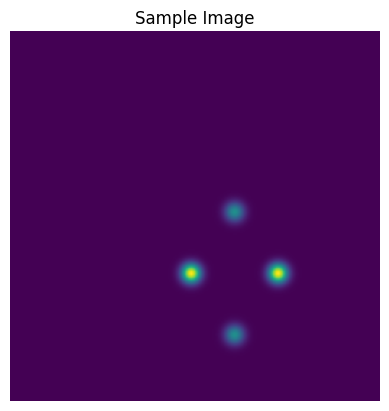

In [18]:
# Read a sample image
sample_image_path = './data/TEM-ImageNet-v1.3/noNoiseNoBackgroundSuperresolution/00001.png'
sample_image = Image.open(sample_image_path)
print(sample_image.size)  # (width, height)

# Convert to tensor for consistency (optional)
transform = transforms.ToTensor()
sample_image_tensor = transform(sample_image)
print(sample_image_tensor.shape)  # (C, H, W)

plt.figure()
plt.imshow(sample_image)
plt.axis('off')
plt.title('Sample Image')
plt.show()

You need to separate real building facade images from the architecture label images—all of which will be of size `256 x 256`.

Define a function that loads image files and outputs two image tensors:

In [19]:
# Define a custom Dataset
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = sorted(list((pathlib.Path(root_dir) / 'noNoise').glob('*.png')))
        self.real_files = sorted(list((pathlib.Path(root_dir) / 'noNoiseNoBackgroundSuperresolution').glob('*.png')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        input_image = Image.open(img_path).convert('RGB')
        img_path = self.real_files[idx]
        real_image = Image.open(img_path).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            real_image = self.transform(real_image)

        return input_image, real_image

Plot a sample of the input (architecture label image) and real (building facade photo) images:

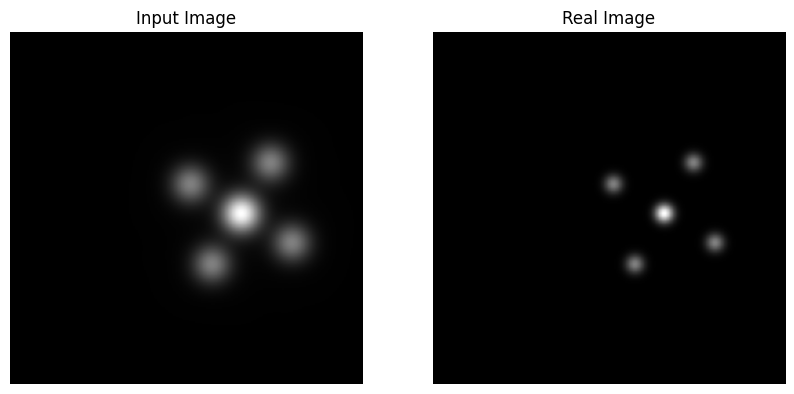

In [21]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

PATH = './data/TEM-ImageNet-v1.3'
# Instantiate dataset and load specific image
dataset = Pix2PixDataset(root_dir=PATH, transform=transform)
inp, re = dataset[99]  # Indexing starts at 0

# Display the input and real images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(inp.permute(1, 2, 0).numpy())
plt.title("Input Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(re.permute(1, 2, 0).numpy())
plt.title("Real Image")
plt.axis('off')

plt.show()


As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e. left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

/opt/conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


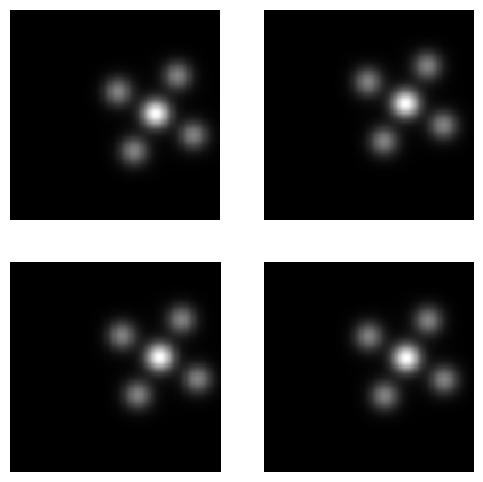

In [22]:
import random
import numpy as np

# Define constants
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((286, 286), Image.NEAREST),
    transforms.RandomCrop((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH), Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Example of data augmentation (similar to random_jitter)
def random_jitter_pytorch(input_image, real_image):
    # Resize to 286x286
    resize = transforms.Resize((286, 286), Image.NEAREST)
    input_image = resize(input_image)
    real_image = resize(real_image)

    # Random crop to 256x256
    i, j, h, w = transforms.RandomCrop.get_params(input_image, output_size=(256, 256))
    input_image = transforms.functional.crop(input_image, i, j, h, w)
    real_image = transforms.functional.crop(real_image, i, j, h, w)

    # Random horizontal flip
    if random.random() > 0.5:
        input_image = transforms.functional.hflip(input_image)
        real_image = transforms.functional.hflip(real_image)

    return input_image, real_image

# Example of normalization
def normalize_pytorch(input_image, real_image):
    normalize = transforms.Normalize((0.5,), (0.5,))
    input_image = normalize(input_image)
    real_image = normalize(real_image)
    return input_image, real_image

# Visualize some augmented images
def visualize_augmentations(inp, re, num=4):
    plt.figure(figsize=(6, 6))
    for i in range(num):
        aug_inp, aug_re = random_jitter_pytorch(inp, re)
        aug_inp = aug_inp.permute(1, 2, 0).numpy()
        plt.subplot(2, 2, i + 1)
        plt.imshow((aug_inp * 0.5) + 0.5)  # Denormalize
        plt.axis('off')
    plt.show()

# Load a sample image and visualize augmentations
dataset = Pix2PixDataset(root_dir=PATH, transform=transform_train)
inp, re = dataset[99]  # Example image
visualize_augmentations(inp, re)


In [23]:
# Create training and test datasets
train_dataset = Pix2PixDataset(root_dir=PATH, transform=transform_train)
test_dataset = Pix2PixDataset(root_dir=PATH, transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

## Build the generator

The generator of your pix2pix cGAN is a _modified_ [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). (You can find out more about it in the [Image segmentation](https://www.tensorflow.org/tutorials/images/segmentation) tutorial and on the [U-Net project website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).)

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

Define the downsampler (encoder):

In [24]:
# Define the downsample block
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_batchnorm=True):
        super(Downsample, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        ]
        if apply_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage
OUTPUT_CHANNELS = 3
down_model = Downsample(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding=1, apply_batchnorm=True)
inp_batch = inp.unsqueeze(0)  # Add batch dimension
down_result = down_model(inp_batch)
print(inp_batch.shape)
print(down_result.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 128, 128])


Define the upsampler (decoder):

In [25]:
# Define the upsample block
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_dropout=False):
        super(Upsample, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if apply_dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU(inplace=True))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage
up_model = Upsample(in_channels=3, out_channels=3, kernel_size=4, stride=2, padding=1, apply_dropout=False)
up_result = up_model(down_result)
print(up_result.shape)


torch.Size([1, 3, 256, 256])


In [26]:
# Define the Generator using U-Net architecture
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        # Downsampling layers
        self.down1 = Downsample(in_channels, 64, apply_batchnorm=False)   # (128, 128, 64)
        self.down2 = Downsample(64, 128)                                  # (64, 64, 128)
        self.down3 = Downsample(128, 256)                                 # (32, 32, 256)
        self.down4 = Downsample(256, 512)                                 # (16, 16, 512)
        self.down5 = Downsample(512, 512)                                 # (8, 8, 512)
        self.down6 = Downsample(512, 512)                                 # (4, 4, 512)
        self.down7 = Downsample(512, 512)                                 # (2, 2, 512)
        self.down8 = Downsample(512, 512)                                 # (1, 1, 512)

        # Upsampling layers
        self.up1 = Upsample(512, 512, apply_dropout=True)                # (2, 2, 1024)
        self.up2 = Upsample(1024, 512, apply_dropout=True)               # (4, 4, 1024)
        self.up3 = Upsample(1024, 512, apply_dropout=True)               # (8, 8, 1024)
        self.up4 = Upsample(1024, 512)                                   # (16, 16, 1024)
        self.up5 = Upsample(1024, 256)                                   # (32, 32, 512)
        self.up6 = Upsample(512, 128)                                    # (64, 64, 256)
        self.up7 = Upsample(256, 64)                                     # (128, 128, 128)

        # Final upsampling layer
        self.last = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # Downsampling
        d1 = self.down1(x)  # (128, 128, 64)
        d2 = self.down2(d1) # (64, 64, 128)
        d3 = self.down3(d2) # (32, 32, 256)
        d4 = self.down4(d3) # (16, 16, 512)
        d5 = self.down5(d4) # (8, 8, 512)
        d6 = self.down6(d5) # (4, 4, 512)
        d7 = self.down7(d6) # (2, 2, 512)
        d8 = self.down8(d7) # (1, 1, 512)

        # Upsampling with skip connections
        u1 = self.up1(d8)           # (2, 2, 1024)
        u1 = torch.cat([u1, d7], dim=1)

        u2 = self.up2(u1)           # (4, 4, 1024)
        u2 = torch.cat([u2, d6], dim=1)

        u3 = self.up3(u2)           # (8, 8, 1024)
        u3 = torch.cat([u3, d5], dim=1)

        u4 = self.up4(u3)           # (16, 16, 1024)
        u4 = torch.cat([u4, d4], dim=1)

        u5 = self.up5(u4)           # (32, 32, 512)
        u5 = torch.cat([u5, d3], dim=1)

        u6 = self.up6(u5)           # (64, 64, 256)
        u6 = torch.cat([u6, d2], dim=1)

        u7 = self.up7(u6)           # (128, 128, 128)
        u7 = torch.cat([u7, d1], dim=1)

        output = self.last(u7)      # (256, 256, 3)
        return output

# Instantiate the generator
generator = GeneratorUNet()
print(generator)


GeneratorUNet(
  (down1): Downsample(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): Downsample(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): Downsample(
    (model): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down4): Downsample(
    (model): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

In [27]:
!pip install graphviz
!pip install pydot
!pip install torchsummary

In [28]:
from torchsummary import summary

# Visualize the generator model summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
summary(generator, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
        Downsample-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
       BatchNorm2d-5          [-1, 128, 64, 64]             256
         LeakyReLU-6          [-1, 128, 64, 64]               0
        Downsample-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
       BatchNorm2d-9          [-1, 256, 32, 32]             512
        LeakyReLU-10          [-1, 256, 32, 32]               0
       Downsample-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
      BatchNorm2d-13          [-1, 512, 16, 16]           1,024
        LeakyReLU-14          [-1, 512,

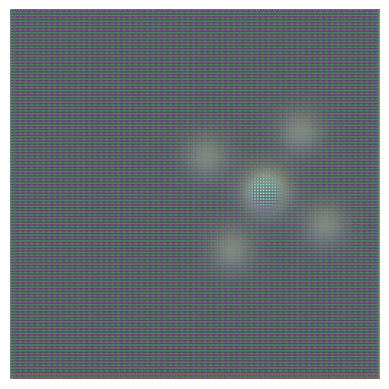

In [29]:
from torchvision import transforms
    
# Test the generator
generator.eval()  # Set to evaluation mode
with torch.no_grad():
    inp_batch = inp.unsqueeze(0).to(device)  # Add batch dimension and move to device
    gen_output = generator(inp_batch).cpu()

# Convert the output tensor to image
gen_image = gen_output[0].permute(1, 2, 0).numpy()
gen_image = (gen_image * 0.5) + 0.5  # Denormalize from [-1,1] to [0,1]

# Display the generated image
plt.figure()
plt.imshow(gen_image)
plt.axis('off')
plt.show()

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [30]:
# Define generator loss
import torch.nn.functional as F

LAMBDA = 100
# Use BCEWithLogitsLoss
criterion_GAN = nn.BCEWithLogitsLoss()
# L1 loss
criterion_L1 = nn.L1Loss()

def generator_loss(disc_generated_output, gen_output, target):
    # GAN loss
    # In PyTorch, target for generator is real (1)
    real_labels = torch.ones_like(disc_generated_output).to(disc_generated_output.device)
    gan_loss = criterion_GAN(disc_generated_output, real_labels)

    # L1 loss
    l1_loss = criterion_L1(gen_output, target)

    # Total generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

The training procedure for the generator is as follows:
![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)
## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs:
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.
    
Let's define the discriminator:

In [31]:
# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=6, features=64):
        super(Discriminator, self).__init__()
        # The input has 3 (input image) + 3 (target image) channels
        self.model = nn.Sequential(
            # Input: (6, 256, 256)
            nn.Conv2d(in_channels, features, kernel_size=4, stride=2, padding=1),  # (64, 128, 128)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1),  # (128, 64, 64)
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1),  # (256, 32, 32)
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ZeroPad2d(1),  # (256, 34, 34)
            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=1, padding=1, bias=False),  # (512, 31, 31)
            nn.BatchNorm2d(features * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ZeroPad2d(1),  # (512, 33, 33)
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=1, padding=1)  # (1, 30, 30)
            # No activation here; BCEWithLogitsLoss will be used
        )

    def forward(self, input_image, target_image):
        # Concatenate image and condition image by channels to produce input
        x = torch.cat([input_image, target_image], dim=1)  # (batch_size, 6, 256, 256)
        return self.model(x)

# Instantiate the discriminator
discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ZeroPad2d((1, 1, 1, 1))
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ZeroPad2d((1, 1, 1, 1))
    (13): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)


*Visualize* the discriminator model architecture:

In [32]:
# Visualize the discriminator model summary
discriminator.to(device)
summary(discriminator, input_size=[(3, 256, 256), (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
       BatchNorm2d-4          [-1, 128, 64, 64]             256
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
       BatchNorm2d-7          [-1, 256, 32, 32]             512
         LeakyReLU-8          [-1, 256, 32, 32]               0
         ZeroPad2d-9          [-1, 256, 34, 34]               0
           Conv2d-10          [-1, 512, 33, 33]       2,097,152
      BatchNorm2d-11          [-1, 512, 33, 33]           1,024
        LeakyReLU-12          [-1, 512, 33, 33]               0
        ZeroPad2d-13          [-1, 512, 35, 35]               0
           Conv2d-14            [-1, 1,

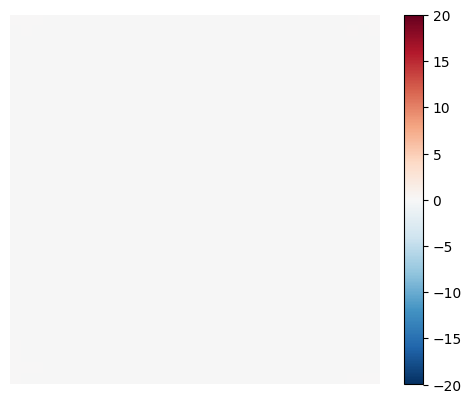

In [33]:
# Test the discriminator
discriminator.eval()  # Set to evaluation mode
with torch.no_grad():
    inp_batch = inp.unsqueeze(0).to(device)
    tar_batch = re.unsqueeze(0).to(device)
    gen_output = generator(inp_batch)
    disc_out = discriminator(inp_batch, gen_output).cpu()

# Convert discriminator output to image for visualization
disc_image = disc_out[0, 0].numpy()  # (30, 30)
plt.imshow(disc_image, vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.axis('off')
plt.show()


### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [34]:
# Define discriminator loss
def discriminator_loss_fn(disc_real_output, disc_generated_output):
    # Real images labels: 1
    real_labels = torch.ones_like(disc_real_output).to(disc_real_output.device)
    # Generated images labels: 0
    fake_labels = torch.zeros_like(disc_generated_output).to(disc_generated_output.device)

    # Calculate loss on real images
    real_loss = criterion_GAN(disc_real_output, real_labels)

    # Calculate loss on fake images
    fake_loss = criterion_GAN(disc_generated_output, fake_labels)

    # Total discriminator loss
    total_disc_loss = real_loss + fake_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


In [35]:
# Define optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# Define checkpoint directory
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt.pth")

# Function to save checkpoints
def save_checkpoint(state, filename=checkpoint_prefix):
    torch.save(state, filename)

# Function to load checkpoints
def load_checkpoint(filename=checkpoint_prefix):
    checkpoint = torch.load(filename)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    generator_optimizer.load_state_dict(checkpoint['generator_optimizer'])
    discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer'])
    print("Checkpoint loaded.")

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since
you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [36]:
# Define function to generate and display images
def generate_images(model, test_input, tar):
    model.eval()
    with torch.no_grad():
        prediction = model(test_input.to(device))
    
    # Move tensors to CPU and denormalize
    test_input = test_input.cpu().squeeze(0)
    tar = tar.cpu().squeeze(0)
    prediction = prediction.cpu().squeeze(0)

    # Denormalize images from [-1,1] to [0,1]
    test_input = (test_input * 0.5) + 0.5
    tar = (tar * 0.5) + 0.5
    prediction = (prediction * 0.5) + 0.5

    # Convert to numpy
    test_input = test_input.permute(1, 2, 0).numpy()
    tar = tar.permute(1, 2, 0).numpy()
    prediction = prediction.permute(1, 2, 0).numpy()

    # Plot the images
    plt.figure(figsize=(15, 15))

    display_list = [test_input, tar, prediction]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

    model.train()

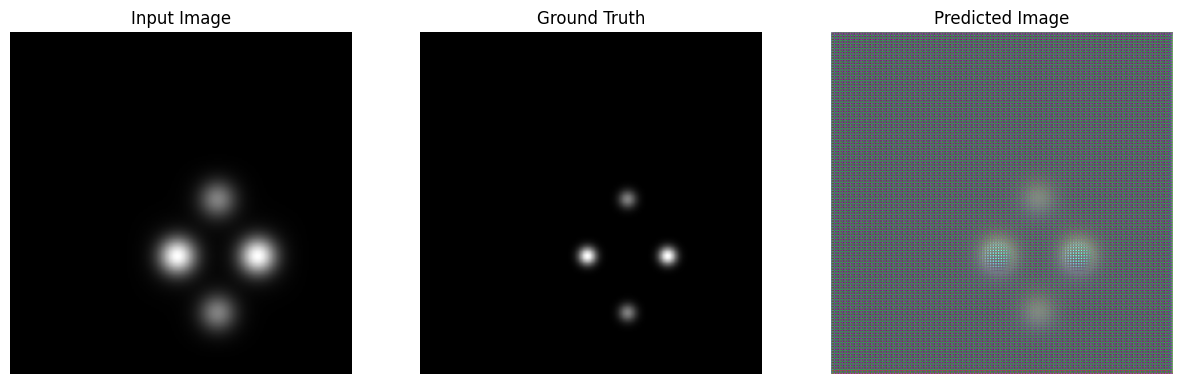

In [37]:
# Display sample generated images from test dataset
for example_input, example_target in test_loader:
    generate_images(generator, example_input, example_target)
    break  # Only take the first batch


## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [38]:
# Set up TensorBoard logging
from torch.utils.tensorboard import SummaryWriter

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir)


The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [39]:
def train_step(input_image, target, step):
    #####################################
    # (1) Train the Discriminator
    #####################################
    discriminator_optimizer.zero_grad()

    # --- Forward pass (Discriminator) ---
    # For realistic gradient flow, we usually don't build a graph through generator
    # while training D. So we use torch.no_grad() to freeze generator parameters here.
    with torch.no_grad():
        fake_image = generator(input_image.to(device))

    disc_real = discriminator(input_image.to(device), target.to(device))            # D(x, y)
    disc_fake = discriminator(input_image.to(device), fake_image.detach())         # D(x, G(x))

    disc_loss = discriminator_loss_fn(disc_real, disc_fake)
    
    # --- Backward pass + update D ---
    disc_loss.backward()
    discriminator_optimizer.step()

    #####################################
    # (2) Train the Generator
    #####################################
    generator_optimizer.zero_grad()

    # --- Forward pass (Generator) ---
    # Now we build a fresh graph for G to enable backprop through it.
    fake_image = generator(input_image.to(device))
    disc_fake_for_G = discriminator(input_image.to(device), fake_image)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_fake_for_G, 
                                                              fake_image, 
                                                              target.to(device))
    
    # --- Backward pass + update G ---
    gen_total_loss.backward()
    generator_optimizer.step()

    #####################################
    # (3) Log the losses to TensorBoard
    #####################################
    summary_writer.add_scalar('disc_loss', disc_loss.item(), step // 1000)
    summary_writer.add_scalar('gen_total_loss', gen_total_loss.item(), step // 1000)
    summary_writer.add_scalar('gen_gan_loss', gen_gan_loss.item(), step // 1000)
    summary_writer.add_scalar('gen_l1_loss', gen_l1_loss.item(), step // 1000)


This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

To launch the viewer paste the following into a code-cell:

Finally, run the training loop:

.
Time taken for 1000 steps: 0.3120841979980469 sec


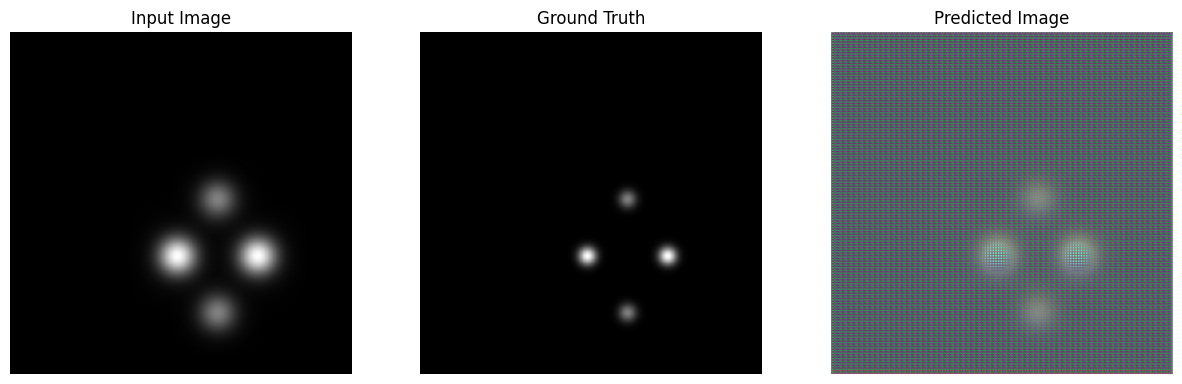

Step: 40k
Checkpoint saved.


In [40]:
# Define the training loop
def fit(train_loader, test_loader, steps):
    discriminator.train()
    
    example_input, example_target = next(iter(test_loader))
    
    start_time = time.time()
    for step, (input_image, target) in enumerate(train_loader, steps):
        generator.train()
        train_step(input_image, target, step)
        
        if step % 10 == 0:
            print('.', end='', flush=True)
        
        if step % 1000 == 0:
            end_time = time.time()
            print(f'\nTime taken for 1000 steps: {end_time - start_time} sec')
            start_time = time.time()
            
            with torch.no_grad():
                generator.eval()
                # Display sample generated images
                generate_images(generator, example_input, example_target)
            print(f"Step: {step//1000}k")
        
        if step % 5000 == 0:
            # Save checkpoint
            save_checkpoint({
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'generator_optimizer': generator_optimizer.state_dict(),
                'discriminator_optimizer': discriminator_optimizer.state_dict(),
            })
            print("Checkpoint saved.")

        if step >= steps:
            break

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

# Example usage:
fit(train_loader, test_loader, steps=40000)


You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

In [41]:
# List contents of the checkpoint directory
import os

print(os.listdir(checkpoint_dir))


['train', 'checkpoint_epoch_15.pth', 'checkpoint_epoch_45.pth', 'ckpt.pth', 'checkpoint_epoch_30.pth']


In [42]:
# Restore the latest checkpoint
def restore_checkpoint(filename=checkpoint_prefix):
    if os.path.exists(filename):
        checkpoint = torch.load(filename)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        generator_optimizer.load_state_dict(checkpoint['generator_optimizer'])
        discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer'])
        print("Checkpoint restored.")
    else:
        print("No checkpoint found.")

restore_checkpoint()


Checkpoint restored.


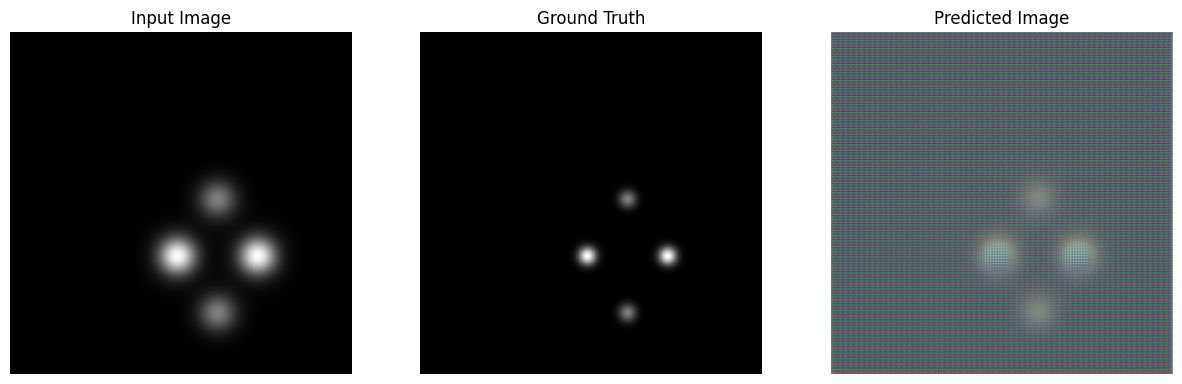

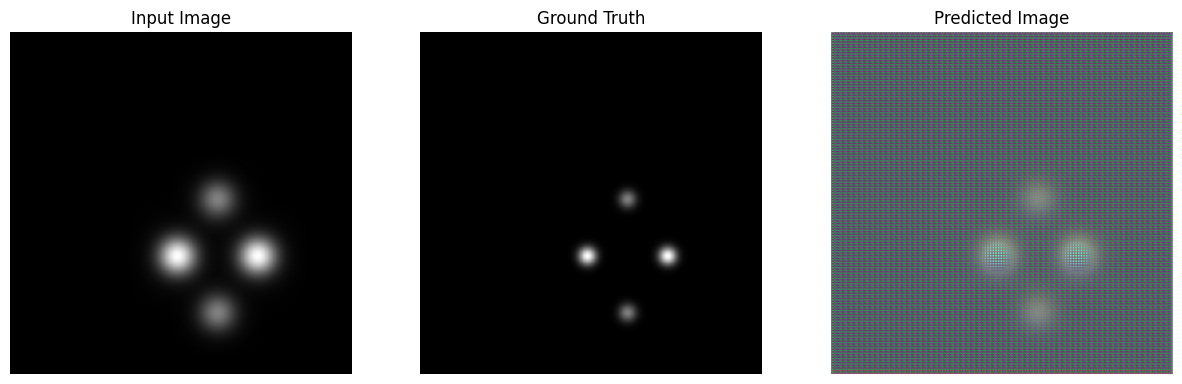

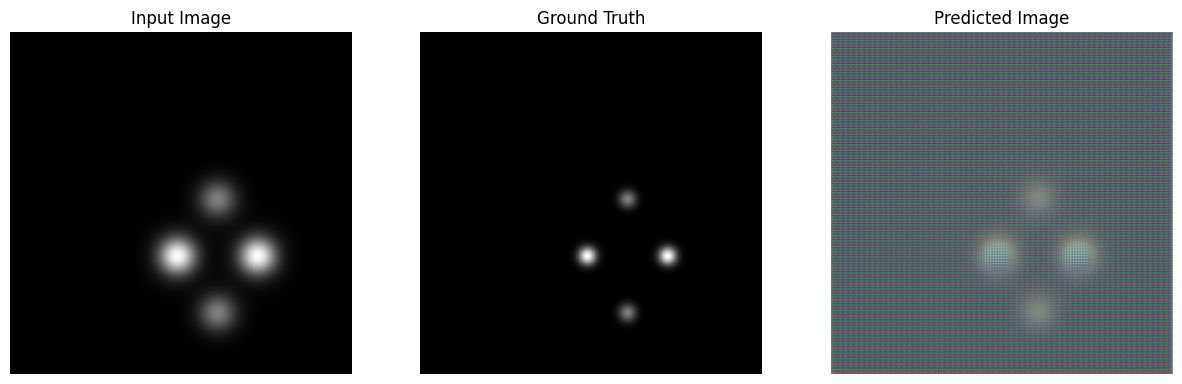

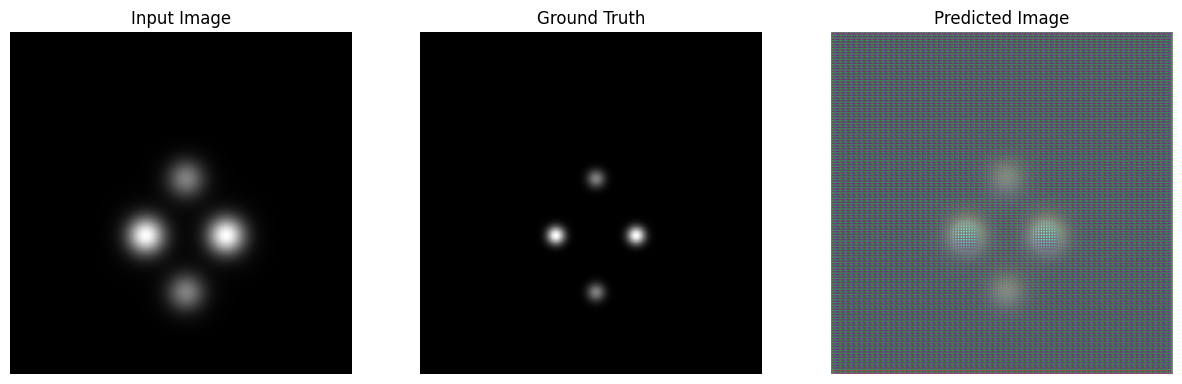

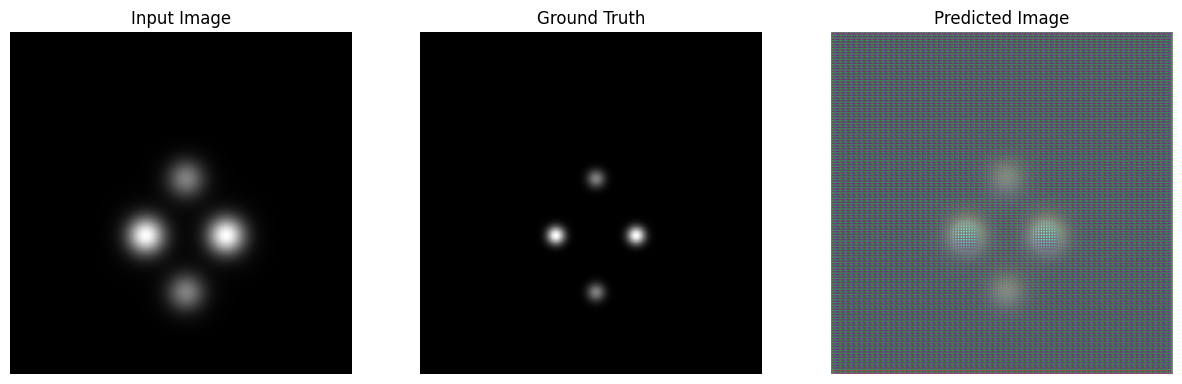

In [43]:
# Run the trained model on a few examples from the test set
def evaluate_on_test_set(model, test_loader, num_examples=5):
    model.eval()
    with torch.no_grad():
        for i, (inp, tar) in enumerate(test_loader):
            if i >= num_examples:
                break
            generate_images(model, inp, tar)
    model.train()

evaluate_on_test_set(generator, test_loader, num_examples=5)

# CycleGAN
This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593), also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples.

This notebook assumes you are familiar with Pix2Pix, which you can learn about in the [Pix2Pix tutorial](https://www.tensorflow.org/tutorials/generative/pix2pix). The code for CycleGAN is similar, the main difference is an additional loss function, and the use of unpaired training data.

CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain.

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

![Output Image 1](https://www.tensorflow.org/tutorials/generative/images/horse2zebra_1.png)
![Output Image 2](https://www.tensorflow.org/tutorials/generative/images/horse2zebra_2.png)

In [ ]:

# Install PyTorch and torchvision
!pip install torch torchvision

# Install additional packages if necessary
!pip install torchmetrics
!pip install albumentations
!pip install matplotlib
!pip install tqdm

  Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl.metadata (28 kB)
Using cached torch-2.6.0-cp310-cp310-manylinux1_x86_64.whl (766.7 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1
    Uninstalling torch-1.13.1:
      Successfully uninstalled torch-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 0.13.1+cu117 requires torch==1.13.1, but you have torch 2.6.0 which is incompatible.
torchvision 0.14.1+cu117 requires torch==1.13.1, but you have torch 2.6.0 which is incompatible.


In [ ]:
# Import necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.transforms.functional as TF

import os
import urllib.request
import zipfile
import time
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output
from tqdm import tqdm

## Input Pipeline

This tutorial trains a model to translate from images of horses, to images of zebras. You can find this dataset and similar ones [here](https://www.tensorflow.org/datasets/catalog/cycle_gan).

As mentioned in the [paper](https://arxiv.org/abs/1703.10593), apply random jittering and mirroring to the training dataset. These are some of the image augmentation techniques that avoids overfitting.

This is similar to what was done in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#load_the_dataset)

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [75]:
DATA_DIR = './data/TEM-ImageNet-v1.3'

class HorseZebraDataset(Dataset):
    def __init__(self, root, mode='train', transform=None):
        self.transform = transform
        self.mode = mode
        self.horse_dir = os.path.join(root, 'noNoise')
        self.zebra_dir = os.path.join(root, 'noNoiseNoBackgroundSuperresolution')
        self.horse_images = sorted(os.listdir(self.horse_dir))[:1000]
        self.zebra_images = sorted(os.listdir(self.zebra_dir))[:1000]
    
    def __len__(self):
        return max(len(self.horse_images), len(self.zebra_images))
    
    def __getitem__(self, idx):
        horse_path = os.path.join(self.horse_dir, self.horse_images[idx % len(self.horse_images)])
        zebra_path = os.path.join(self.zebra_dir, self.zebra_images[idx % len(self.zebra_images)])
        
        horse_image = Image.open(horse_path).convert('RGB')
        zebra_image = Image.open(zebra_path).convert('RGB')
        
        if self.transform:
            horse_image = self.transform(horse_image)
            zebra_image = self.transform(zebra_image)
        
        return horse_image, zebra_image

# Instantiate datasets
train_transform = transforms.Compose([
    transforms.Resize((286, 286), Image.BICUBIC),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = HorseZebraDataset(DATA_DIR, mode='train', transform=train_transform)
test_dataset = HorseZebraDataset(DATA_DIR, mode='test', transform=test_transform)

# Create DataLoaders
BATCH_SIZE = 1
BUFFER_SIZE = 1000

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [76]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [77]:
sample_horse, sample_zebra = next(iter(train_loader))

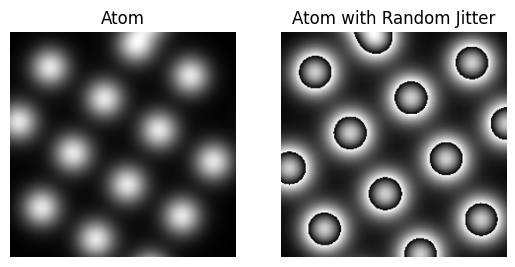

In [78]:
# Visualize original and jittered horse images

def imshow(image, title):
    image = image * 0.5 + 0.5  # Denormalize
    np_image = image.cpu().numpy().transpose(1, 2, 0)
    plt.imshow(np_image)
    plt.title(title)
    plt.axis('off')

# Original Horse Image
plt.subplot(1, 2, 1)
imshow(sample_horse[0], 'Atom')

# Apply random jitter to the horse image for visualization
jitter_transform = transforms.Compose([
    transforms.Resize((286, 286), Image.BICUBIC),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip()
])

jittered_horse = jitter_transform(transforms.ToPILImage()(sample_horse[0]))
jittered_horse = test_transform(jittered_horse)  # Normalize
plt.subplot(1, 2, 2)
imshow(jittered_horse, 'Atom with Random Jitter')

plt.show()


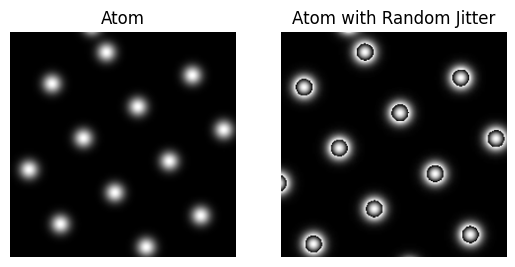

In [79]:
# Visualize original and jittered zebra images

# Original Zebra Image
plt.subplot(1, 2, 1)
imshow(sample_zebra[0], 'Atom')

# Apply random jitter to the zebra image for visualization
jittered_zebra = jitter_transform(transforms.ToPILImage()(sample_zebra[0]))
jittered_zebra = test_transform(jittered_zebra)  # Normalize
plt.subplot(1, 2, 2)
imshow(jittered_zebra, 'Atom with Random Jitter')

plt.show()


In [80]:
# Define Generator and Discriminator models using U-Net architecture

# Define the U-Net Generator
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, ngf=64):
        super(UNetGenerator, self).__init__()
        # Implement U-Net architecture
        # For brevity, using a simplified version
        self.down1 = self.down_block(in_channels, ngf)
        self.down2 = self.down_block(ngf, ngf*2)
        self.down3 = self.down_block(ngf*2, ngf*4)
        self.down4 = self.down_block(ngf*4, ngf*8)
        self.up1 = self.up_block(ngf*8, ngf*4)
        self.up2 = self.up_block(ngf*4, ngf*2)
        self.up3 = self.up_block(ngf*2, ngf)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(ngf, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def down_block(self, in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)
    
    def up_block(self, in_channels, out_channels, dropout=0.0):
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        u1 = self.up1(d4)
        u2 = self.up2(u1 + d3)  # Skip connection
        u3 = self.up3(u2 + d2)
        return self.final(u3 + d1)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        # PatchGAN discriminator
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
    
    def forward(self, x):
        return self.model(x)
    
# Initialize models
OUTPUT_CHANNELS = 3

generator_g = UNetGenerator(in_channels=3, out_channels=OUTPUT_CHANNELS).to('cuda')
generator_f = UNetGenerator(in_channels=3, out_channels=OUTPUT_CHANNELS).to('cuda')

discriminator_x = Discriminator(in_channels=3).to('cuda')
discriminator_y = Discriminator(in_channels=3).to('cuda')


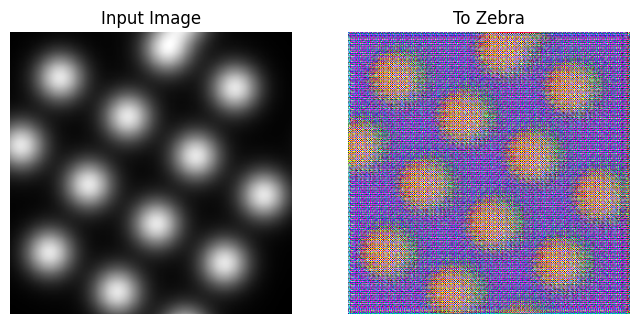

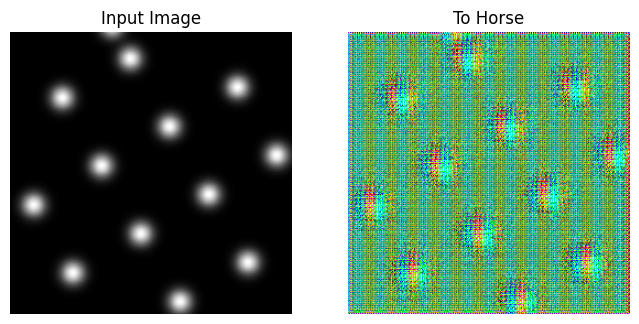

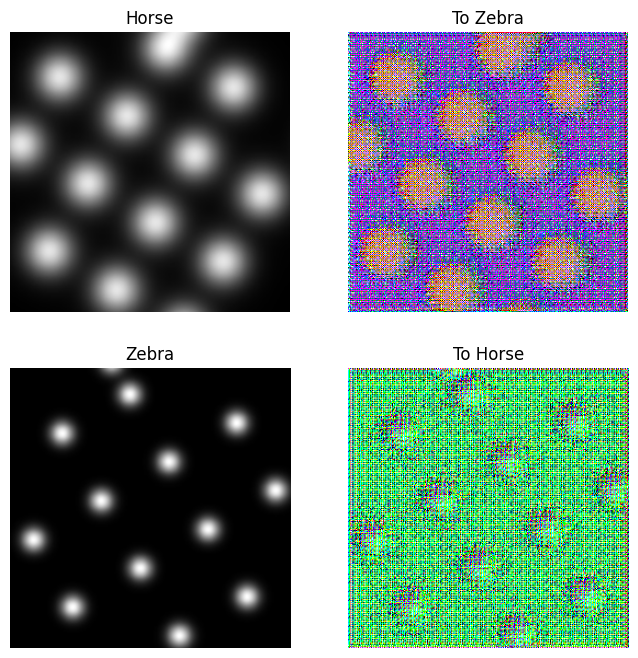

In [81]:
# Cell 84: Generate images using the generators and visualize

def generate_images(model, test_input, title='Generated Image'):
    model.eval()
    with torch.no_grad():
        prediction = model(test_input.to('cuda'))
    model.train()
    
    plt.figure(figsize=(8, 8))
    # Input Image
    plt.subplot(1, 2, 1)
    imshow(test_input[0], 'Input Image')
    # Generated Image
    plt.subplot(1, 2, 2)
    imshow(prediction[0].cpu(), title)
    plt.show()

# Generate images
generate_images(generator_g, sample_horse, title='To Zebra')
generate_images(generator_f, sample_zebra, title='To Horse')

# Display multiple images
plt.figure(figsize=(8, 8))
contrast = 8

# Move sample to GPU
sample_horse_gpu = sample_horse.to('cuda')
sample_zebra_gpu = sample_zebra.to('cuda')

to_zebra = generator_g(sample_horse_gpu)
to_horse = generator_f(sample_zebra_gpu)

imgs = [sample_horse, to_zebra.cpu(), sample_zebra, to_horse.cpu()]
titles = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(titles[i])
    img = imgs[i][0] * 0.5 + 0.5  # Denormalize
    img = img.detach().numpy().transpose(1, 2, 0)
    if i % 2 == 0:
        plt.imshow(img)
    else:
        plt.imshow((imgs[i][0] * 0.5 * contrast + 0.5).clamp(0, 1).detach().numpy().transpose(1, 2, 0))
    plt.axis('off')
plt.show()


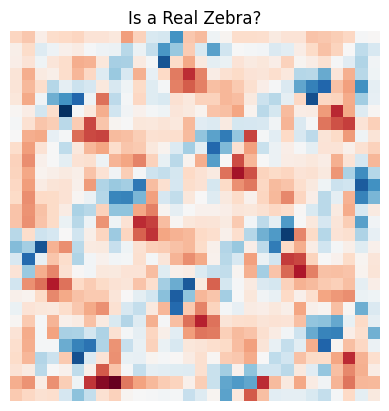

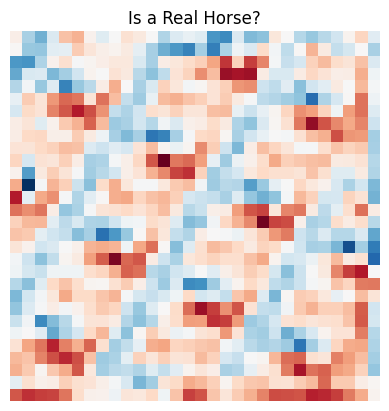

In [82]:
# Cell 85: Visualize discriminator outputs

def visualize_discriminator_output(discriminator, real_image, title='Discriminator Output'):
    discriminator.eval()
    with torch.no_grad():
        output = discriminator(real_image.to('cuda'))
    discriminator.train()
    
    plt.title(title)
    plt.imshow(output.cpu().squeeze().numpy(), cmap='RdBu_r')
    plt.axis('off')
    plt.show()

# Visualize discriminator outputs for real images
visualize_discriminator_output(discriminator_y, sample_zebra, 'Is a Real Zebra?')
visualize_discriminator_output(discriminator_x, sample_horse, 'Is a Real Horse?')

## Loss function
In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The discriminator loss and the generator loss are similar to the ones used in [pix2pix](https://www.tensorflow.org/tutorials/generative/pix2pix#build_the_generator).

In [83]:
LAMBDA = 10

In [84]:
# Define loss functions

# Adversarial loss (Binary Cross Entropy)
adversarial_loss = nn.MSELoss().to('cuda')  # Using MSE for LSGAN
# Cycle consistency loss (L1)
cycle_loss = nn.L1Loss().to('cuda')
# Identity loss (L1)
identity_loss = nn.L1Loss().to('cuda')


In [85]:
# Define discriminator loss functions

def discriminator_loss_fn(real_output, fake_output):
    # Real images should be classified as ones
    real_loss = adversarial_loss(real_output, torch.ones_like(real_output).to('cuda'))
    # Fake images should be classified as zeros
    fake_loss = adversarial_loss(fake_output, torch.zeros_like(fake_output).to('cuda'))
    total_disc_loss = (real_loss + fake_loss) * 0.5
    return total_disc_loss

In [86]:
# Define generator adversarial loss

def generator_loss_fn(fake_output):
    # Generator tries to make discriminator classify fake images as real
    return adversarial_loss(fake_output, torch.ones_like(fake_output).to('cuda'))

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the  original sentence.

In cycle consistency loss,

* Image $X$ is passed via generator $G$ that yields generated image $\hat{Y}$.
* Generated image $\hat{Y}$ is passed via generator $F$ that yields cycled image $\hat{X}$.
* Mean absolute error is calculated between $X$ and $\hat{X}$.

$$forward\ cycle\ consistency\ loss: X -> G(X) -> F(G(X)) \sim \hat{X}$$

$$backward\ cycle\ consistency\ loss: Y -> F(Y) -> G(F(Y)) \sim \hat{Y}$$


![Cycle loss](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cycle_loss.png?raw=1)

In [87]:
# Define cycle consistency loss

def calc_cycle_loss(real_image, cycled_image):
    return LAMBDA * cycle_loss(cycled_image, real_image)

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [88]:
# Define identity loss

def identity_loss_fn(real_image, same_image):
    return LAMBDA * 0.5 * identity_loss(same_image, real_image)

Initialize the optimizers for all the generators and the discriminators.

In [89]:
# Initialize optimizers
lr = 2e-4
beta1 = 0.5

import itertools

optimizer_G = optim.Adam(itertools.chain(generator_g.parameters(), generator_f.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D_x = optim.Adam(discriminator_x.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_y = optim.Adam(discriminator_y.parameters(), lr=lr, betas=(beta1, 0.999))

In [90]:
# Set up checkpointing to save and load model weights

import itertools

# Define directory to save checkpoints
CHECKPOINT_DIR = './checkpoints/train/'

# Create directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define a function to save checkpoints
def save_checkpoint(epoch):
    torch.save({
        'epoch': epoch,
        'generator_g_state_dict': generator_g.state_dict(),
        'generator_f_state_dict': generator_f.state_dict(),
        'discriminator_x_state_dict': discriminator_x.state_dict(),
        'discriminator_y_state_dict': discriminator_y.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_x_state_dict': optimizer_D_x.state_dict(),
        'optimizer_D_y_state_dict': optimizer_D_y.state_dict(),
    }, os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch}.pth'))
    print(f'Checkpoint saved for epoch {epoch}')

# Define a function to load the latest checkpoint
def load_checkpoint():
    checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('_')[-1].split('.pth')[0]))
        checkpoint = torch.load(os.path.join(CHECKPOINT_DIR, latest_checkpoint))
        generator_g.load_state_dict(checkpoint['generator_g_state_dict'])
        generator_f.load_state_dict(checkpoint['generator_f_state_dict'])
        discriminator_x.load_state_dict(checkpoint['discriminator_x_state_dict'])
        discriminator_y.load_state_dict(checkpoint['discriminator_y_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D_x.load_state_dict(checkpoint['optimizer_D_x_state_dict'])
        optimizer_D_y.load_state_dict(checkpoint['optimizer_D_y_state_dict'])
        epoch = checkpoint['epoch']
        print(f'Loaded checkpoint from epoch {epoch}')
        return epoch
    else:
        print('No checkpoint found')
        return 0

# Load the latest checkpoint if available
start_epoch = load_checkpoint()


Loaded checkpoint from epoch 40


## Training

Note: This example model is trained for fewer epochs (40) than the paper (200) to keep training time reasonable for this tutorial. Predictions may be less accurate.

In [91]:
# Define a function to generate and display images

def generate_images(model, test_input, title='Predicted Image'):
    model.eval()
    with torch.no_grad():
        prediction = model(test_input.to('cuda'))
    model.train()
    
    plt.figure(figsize=(12, 12))
    
    display_list = [test_input[0], prediction[0]]
    titles = ['Input Image', title]
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        imshow(display_list[i], titles[i])
    plt.show()


Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [92]:
# Define the training step

def train_step(real_x, real_y):
    # Move data to GPU
    real_x = real_x.to('cuda')
    real_y = real_y.to('cuda')
    
    # =======================
    # Train Generators
    # =======================
    optimizer_G.zero_grad()
    
    # Translate X -> Y
    fake_y = generator_g(real_x)
    # Translate Y -> X
    fake_x = generator_f(real_y)
    
    # Cycle Y -> X -> Y
    cycled_y = generator_g(fake_x)
    # Cycle X -> Y -> X
    cycled_x = generator_f(fake_y)
    
    # Identity mapping
    same_y = generator_g(real_y)
    same_x = generator_f(real_x)
    
    # Generator adversarial loss
    loss_G_g = generator_loss_fn(discriminator_y(fake_y))
    loss_G_f = generator_loss_fn(discriminator_x(fake_x))
    
    # Cycle consistency loss
    loss_cycle = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Identity loss
    loss_identity = identity_loss_fn(real_y, same_y) + identity_loss_fn(real_x, same_x)
    
    # Total generator loss
    total_G_loss = loss_G_g + loss_G_f + loss_cycle + loss_identity
    total_G_loss.backward()
    optimizer_G.step()
    
    # =======================
    # Train Discriminator X
    # =======================
    optimizer_D_x.zero_grad()
    
    # Discriminator X on real and fake images
    disc_real_x = discriminator_x(real_x)
    disc_fake_x = discriminator_x(fake_x.detach())
    
    # Discriminator loss
    loss_D_x = discriminator_loss_fn(disc_real_x, disc_fake_x)
    loss_D_x.backward()
    optimizer_D_x.step()
    
    # =======================
    # Train Discriminator Y
    # =======================
    optimizer_D_y.zero_grad()
    
    # Discriminator Y on real and fake images
    disc_real_y = discriminator_y(real_y)
    disc_fake_y = discriminator_y(fake_y.detach())
    
    # Discriminator loss
    loss_D_y = discriminator_loss_fn(disc_real_y, disc_fake_y)
    loss_D_y.backward()
    optimizer_D_y.step()
    
    return total_G_loss.item(), loss_D_x.item(), loss_D_y.item()


In [93]:
# Training loop

EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start_time = time.time()
    total_G_loss = 0
    total_D_x_loss = 0
    total_D_y_loss = 0
    n = 0
    
    for real_x, real_y in train_loader:
        G_loss, D_x_loss, D_y_loss = train_step(real_x, real_y)
        total_G_loss += G_loss
        total_D_x_loss += D_x_loss
        total_D_y_loss += D_y_loss
        n += 1
        if n % 10 == 0:
            print('.', end='')
    
    # Average losses
    avg_G_loss = total_G_loss / n
    avg_D_x_loss = total_D_x_loss / n
    avg_D_y_loss = total_D_y_loss / n
    
    # Generate and display images after each epoch
    sample = next(iter(test_loader))
    generate_images(generator_g, sample[0], title='To Zebra')
    
    # Save checkpoints every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(epoch + 1)
    
    end_time = time.time()
    print(f'\nEpoch {epoch+1} | Generator Loss: {avg_G_loss:.4f} | Discriminator X Loss: {avg_D_x_loss:.4f} | Discriminator Y Loss: {avg_D_y_loss:.4f}')
    print(f'Time taken for epoch {epoch+1}: {end_time - start_time:.2f} sec\n')


## Generate using test dataset

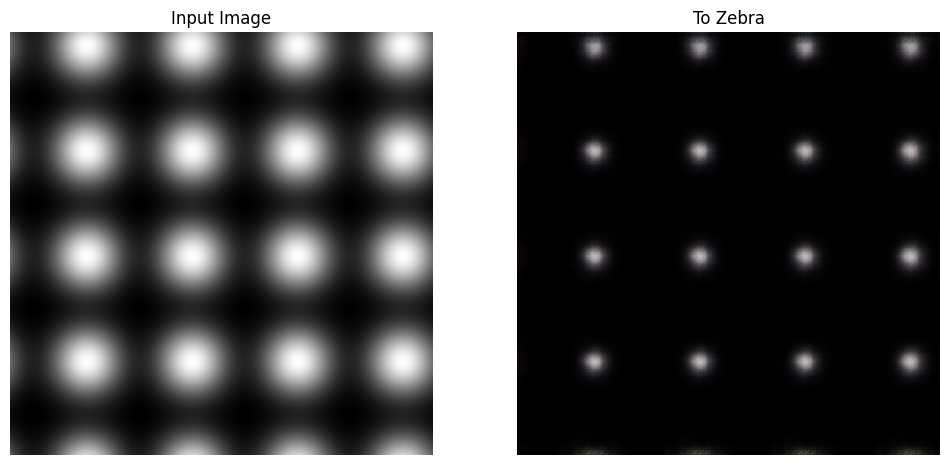

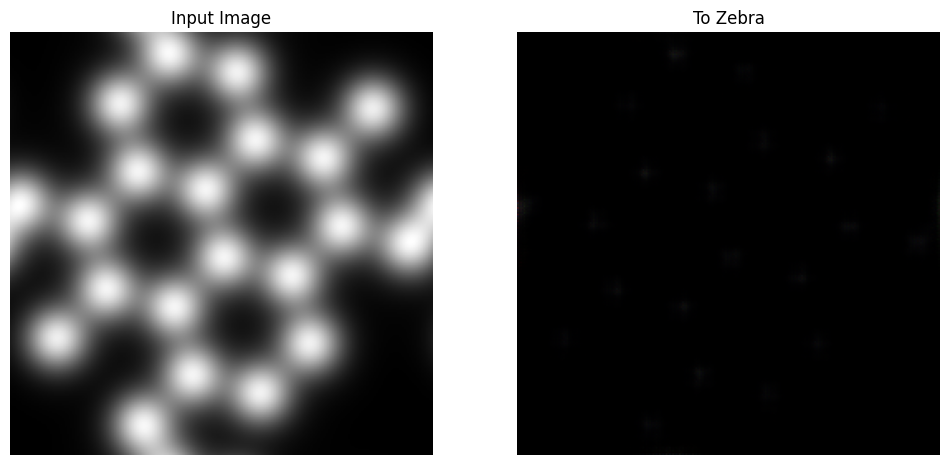

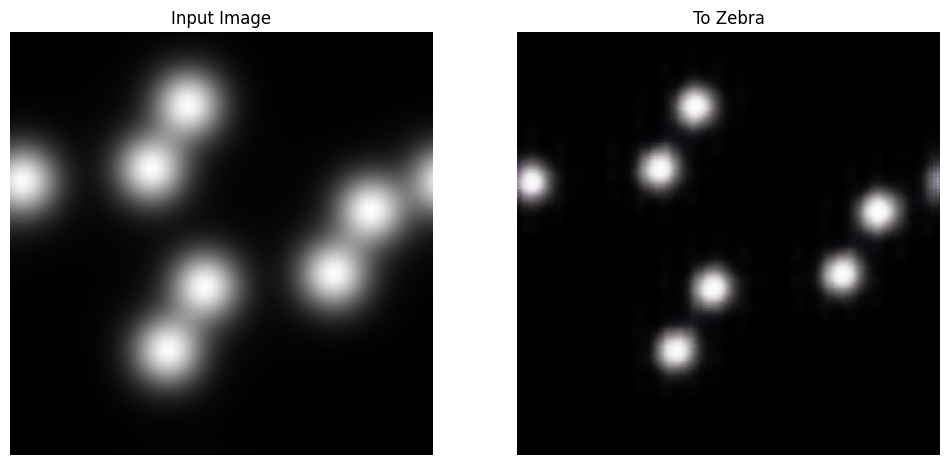

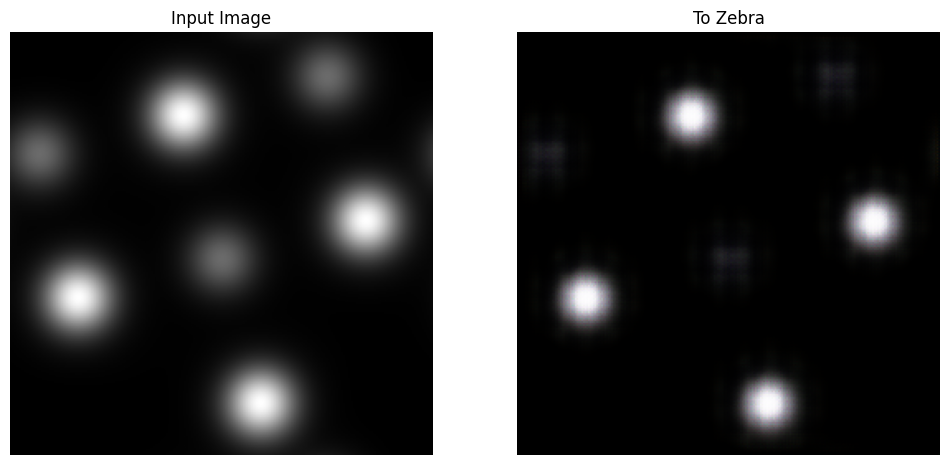

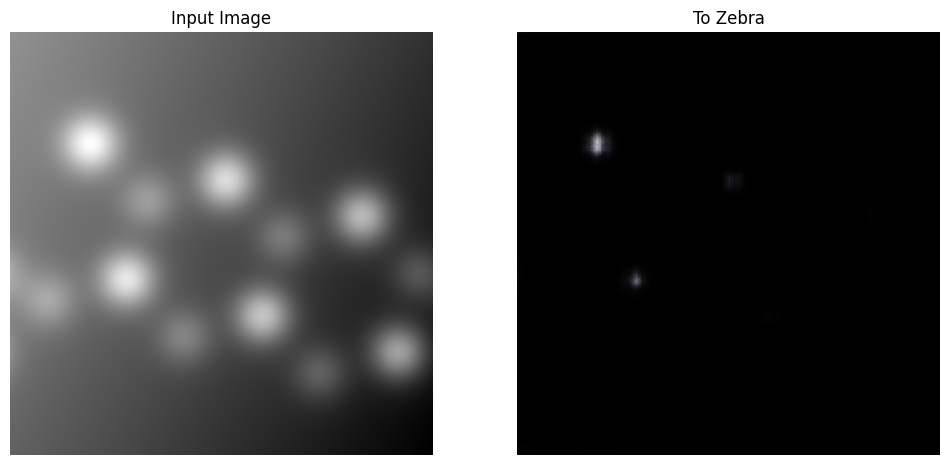

In [94]:
# Generate and display images using the trained model on the test dataset

for i, (inp, _) in enumerate(test_loader):
    if i >= 5:
        break
    generate_images(generator_g, inp, title='To Zebra')
